### Text Classification application for easyJet
###### Work order classifier

In [1]:
#Load libraries
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score

In [2]:
# Load dataset with work orders and their labels
# Excluded records that had missing labels
# A subset of the original dataset, 
# subsampling only from the six most frequent classes, keeping original proportions

df = pd.read_csv('Sample_wo_data.csv')[['description','ata_short']]
print('Number of rows: '+str(len(df)))

df.head()

Number of rows: 352388


,description,ata_short
0,PERFORM ON PN: CFM56-5B4-3 SN:699420OP CHECK M...,72
1,CREW RESET=> FMGC 2 SUCCESSFUL RESET ON GND AS...,5
2,OIL UPLIFT REPORTED BY IAN H,12
3,LTM DEF NO 5000690682-0010ENG 2 BLEED AIR FAUL...,72
4,PERFORM DAILY CHECK,5


###### Check for missing decriptions, remove these records

In [3]:
print(df.description.isnull().any())
df.dropna(inplace = True)
print(len(df))

True
352386


In [4]:
df.groupby('ata_short').count()

,description
ata_short,
5,125453
12,44193
25,88878
32,28330
33,43386
72,22146


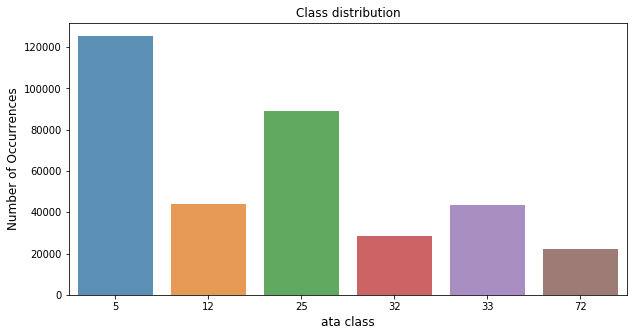

In [5]:
y_counts = df.ata_short.value_counts()
plt.figure(figsize=(10,5))
sns.barplot(y_counts.index, y_counts.values, alpha=0.8)
plt.title('Class distribution')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('ata class', fontsize=12)
plt.show()

In [6]:
X = df.description
y = df.ata_short

###### Remove all numbers and underscores from text

In [7]:
X = X.str.replace('[\d_]+','')

###### Split to train/test set

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100, stratify = y)

### Feature generation
Use countvectorizer (bag of words) and then Tfidftransformer (uses inverse document frequencty to account for relevance of words)

Countvectorizer converts all characters to lowercase by default. Punctuation is ignored. 
Only words with >= 2 characters are considered
Use bigrams and remove stop_words

###### Bag of words

In [9]:
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer(ngram_range = (1,2), stop_words = 'english', min_df = 2).fit(X_train)
X_train_counts = count_vect.transform(X_train)

In [10]:
vocabulary = count_vect.vocabulary_

In [16]:
X_train_counts.shape

(281908, 93393)

In [11]:
#Get the most frequent words
sum_words = X_train_counts.sum(axis=0) 
words_freq = [(word, sum_words[0, idx]) for word, idx in vocabulary.items()]
words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
print(words_freq[:100])

[('check', 96571), ('daily', 79518), ('perform', 74065), ('daily check', 70301), ('reported', 52441), ('perform daily', 49962), ('task', 43177), ('oil', 42670), ('ref', 40590), ('inspection', 33250), ('cfm', 30825), ('engine', 29574), ('required', 29556), ('light', 27138), ('seat', 26162), ('uplift', 25085), ('oil uplift', 25050), ('fan', 24525), ('eze', 20990), ('installed', 20978), ('pn', 19419), ('iaw', 19342), ('sn', 19081), ('form', 18627), ('finding', 18087), ('order', 17621), ('bow', 17485), ('form eze', 17472), ('amp', 16089), ('amp task', 16073), ('lh', 15923), ('fwd', 15850), ('rh', 15753), ('amm', 15555), ('door', 15170), ('easyjet', 15113), ('inop', 15016), ('descr', 14980), ('em', 14929), ('work', 14366), ('international', 14310), ('cfm international', 14310), ('em engine', 13967), ('pn cfm', 13845), ('installed em', 13794), ('note', 13752), ('uplift reported', 13659), ('task installed', 13639), ('etpm', 13579), ('gear', 13247), ('landing', 13132), ('finding bow', 12625), 

In [12]:
# Get the least frequent words
print(words_freq[-100:])

[('duct distribution', 2), ('distribution bay', 2), ('bay air', 2), ('air condibay', 2), ('condibay torn', 2), ('total reported', 2), ('duct pack', 2), ('wet requires', 2), ('support needed', 2), ('exposed composite', 2), ('reported fod', 2), ('item neon', 2), ('qrhsuccessful', 2), ('iaw qrhsuccessful', 2), ('gezdn req', 2), ('cushion badcondition', 2), ('chord missing', 2), ('ezin', 2), ('lh loose', 2), ('pocket brokenspares', 2), ('samplestake', 2), ('hydraulisystems', 2), ('ioana', 2), ('dalla', 2), ('barbaairbus', 2), ('expert', 2), ('parc', 2), ('activités', 2), ('marius', 2), ('terce', 2), ('francephone', 2), ('fluid samplestake', 2), ('samplestake sets', 2), ('sets hydraulic', 2), ('yellow hydraulisystems', 2), ('hydraulisystems station', 2), ('holdings analysis', 2), ('forward set', 2), ('tel forward', 2), ('forward second', 2), ('second set', 2), ('samples att', 2), ('att ioana', 2), ('ioana dalla', 2), ('dalla barbaairbus', 2), ('barbaairbus ndt', 2), ('ndt expert', 2), ('exp

In [13]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB(alpha = 0.1).fit(X_train_counts, y_train)

In [14]:
from sklearn.metrics import accuracy_score
X_test_counts = count_vect.transform(X_test)
y_pred  = clf.predict(X_test_counts)

In [15]:
def print_results(y_test,y_pred):
    acc = accuracy_score(y_test,y_pred)
    print('Overall accuracy : '+str(acc))
    f1_micro = f1_score(y_test, y_pred, average = 'micro')
    f1_macro = f1_score(y_test, y_pred, average = 'macro')
    f1_all = f1_score(y_test, y_pred, average = None)

    print('F1 micro : ' +str(f1_micro))
    print('F1 macro : ' +str(f1_macro))
    print('F1 for each class : ' +str(f1_all))

In [17]:
print_results(y_test,y_pred)

Overall accuracy : 0.9253384034734243
F1 micro : 0.9253384034734244
F1 macro : 0.9248130636326635
F1 for each class : [0.92152674 0.86888246 0.94595718 0.92040272 0.93590742 0.95620186]


###### TFIDF

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vect = TfidfVectorizer(ngram_range = (1,2), stop_words = 'english', min_df = 2).fit(X_train)
X_train_tfidf = tfidf_vect.transform(X_train)

In [23]:
clf2 = MultinomialNB(alpha = 0.1).fit(X_train_tfidf, y_train)
X_test_tfidf = tfidf_vect.transform(X_test)
y_pred  = clf.predict(X_test_tfidf) # MISTAKE!
acc = accuracy_score(y_test,y_pred)

In [24]:
print_results(y_test,y_pred)

Overall accuracy : 0.9307301569284032
F1 micro : 0.9307301569284032
F1 macro : 0.9304127942950728
F1 for each class : [0.92634606 0.87992361 0.94946764 0.92596455 0.94248985 0.95828505]


###### SVM classifier (linear with stochastic gradient descent for faster computation)

In [25]:
from sklearn.linear_model import SGDClassifier
clf_svg = SGDClassifier(loss='hinge', penalty='l2', alpha = 1e-05).fit(X_train_tfidf,y_train)
y_pred_svg  = clf_svg.predict(X_test_tfidf)

In [27]:
print_results(y_test,y_pred_svg)

Overall accuracy : 0.9465790743210647
F1 micro : 0.9465790743210647
F1 macro : 0.9483497787262859
F1 for each class : [0.94288382 0.9225088  0.95365794 0.9419366  0.95557612 0.9735354 ]


In [28]:
#check accuracy in training set to do a sanity check for overfitting
pred_train = clf_svg.predict(X_train_tfidf)
acc_train = accuracy_score(y_train,pred_train)
print(acc_train)

0.9536089788157839


###### Stemming

In [29]:
from gensim.parsing.porter import PorterStemmer

p = PorterStemmer()

for i in range(len(X)):
    X.iloc[i] = p.stem_sentence(X.iloc[i])
print(X.head())

0    perform on pn: cfm-b- sn:op check mcd (m)amp t...
1    crew reset=> fmgc success reset on gnd as per ...
2                           oil uplift report by ian h
3    ltm def no -eng bleed air fault encount dure e...
4                                  perform daili check
Name: description, dtype: object


In [32]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=100)
count_vectorize = CountVectorizer(ngram_range = (1,2), stop_words = 'english', min_df = 2)

tfidf_transform = TfidfTransformer()

pipeline_svm = Pipeline([('bow', count_vectorize),('tfidf', tfidf_transform),('clf_svg', 
                              SGDClassifier(loss='hinge', penalty='l2', alpha = 1e-05))])
#pipeline_svm = Pipeline([('bow', count_vectorize),('tfidf', tfidf_transform),('clf_svm', SVC(kernel = 'rbf'))])

clf_stem = pipeline_svm.fit(X_train, y_train)
y_pred_stem  = clf_stem.predict(X_test)

In [33]:
print_results(y_test,y_pred_stem)

Overall accuracy : 0.9481256562331508
F1 micro : 0.9481256562331508
F1 macro : 0.9496435408616378
F1 for each class : [0.94562437 0.92971138 0.9534616  0.94611187 0.95370693 0.96924511]
